In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
from pathlib import Path
import json, shutil
from tqdm import tqdm
from datetime import datetime
from omegaconf import OmegaConf
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt
from PIL import Image
import torch
lt.monkey_patch()

sys.path.append("../../src")
from musubi_tuner.fpack_1fmc_generate import FramePack_1fmc
from musubi_tuner.utils.preproc_utils import get_info_from_vistorybench, get_panel_layout
from musubi_tuner.utils.viz_utils import convert_result_to_df_wpose, annot_viz, draw_final_img

sys.path.append("/lustre/fs1/home/yo564250/workspace/whisperer/datasets/storyviz/vistorybench")
# sys.path.append("/projects/bffz/ykwon4/vistorybench/")
from vistorybench.data_process.dataset_process.dataset_load import StoryDataset
vistory_dataset_path = Path("/lustre/fs1/groups/chenchen/patrick/ViStoryBench/dataset/ViStory")
vistory_dataset = StoryDataset(vistory_dataset_path)

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
INFO:root:Xformers is installed!
INFO:root:Flash Attn is installed!
INFO:root:Sage Attn is installed!


Trying to import sageattention
Successfully imported sageattention
model_path is /lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/musubi_tuner/ckpts/hr16/yolox-onnx/yolox_l.torchscript.pt
model_path is /lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/musubi_tuner/ckpts/hr16/DWPose-TorchScript-BatchSize5/dw-ll_ucoco_384_bs5.torchscript.pt

DWPose: Using yolox_l.torchscript.pt for bbox detection and dw-ll_ucoco_384_bs5.torchscript.pt for pose estimation
DWPose: Caching TorchScript module yolox_l.torchscript.pt on ...
DWPose: Caching TorchScript module dw-ll_ucoco_384_bs5.torchscript.pt on ...


/home/yo564250/conda-envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yo564250/conda-envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [2]:
framepack_model = FramePack_1fmc(
    lora_path = "../../outputs/training/idmask_control_lora_wrope_v2_multi/idmask_control_lora_wrope_v2_multi_tmp-step00002000.safetensors"
)

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Image Projection: False
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /lustre/fs1/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, device=cuda:0
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /lustre/fs1/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, info=_IncompatibleKeys(missing_keys=[], unexpected_keys=['image_projection.down.bias', 'image_projection.down.weight', 'image_projection.up.bias', 'image_projection.up.weight'])
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from ../../outputs/training/idmask_control_lora_wrope_v2_multi/idmask_control_lora_wrope_v2_multi_tmp-step00002000.safetensors with multiplier 1.0
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.n

Model, VAE, Text Encoders, LoRA loaded.


In [3]:
main_layout_path = Path("/groups/chenchen/patrick/ViStoryBench/gen_layouts_bulk/20250927_101053")
story_num = '02'

layouts = sorted(list(main_layout_path.glob(f"story_{story_num}*")))
print([x.stem for x in layouts])

['story_02-pages_1_6', 'story_02-pages_7_10']


In [4]:
start_shot_num, end_shot_num = 1, 6
author_output_dir = main_layout_path / f"story_{story_num}-pages_{start_shot_num}_{end_shot_num}"

config_layout = json.loads((author_output_dir / "config.json").read_text())
joint_layout = json.loads((author_output_dir / "pose_layout.json").read_text())
page_w, page_h = config_layout['page_size']

results_dict = {}

{'David': ['/lustre/fs1/groups/chenchen/patrick/ViStoryBench/dataset/ViStory/02/image/David/00.jpg'], "David's Mom": ["/lustre/fs1/groups/chenchen/patrick/ViStoryBench/dataset/ViStory/02/image/David's Mom/00.jpg"]}
1310232967


  0%|          | 0/25 [00:00<?, ?it/s]

/lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/musubi_tuner/frame_pack/hunyuan_video_packed.py:794: UserWarning: You are using Attention Mask, but sageattn does not support attention masking. Moving to normal SDPA
  warnings.warn(f"You are using Attention Mask, but {attn_mode} does not support attention masking. Moving to normal SDPA")
/lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/musubi_tuner/utils/viz_utils.py:190: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/musubi_tuner/utils/viz_utils.py:150: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.savefig(buf, format='png')


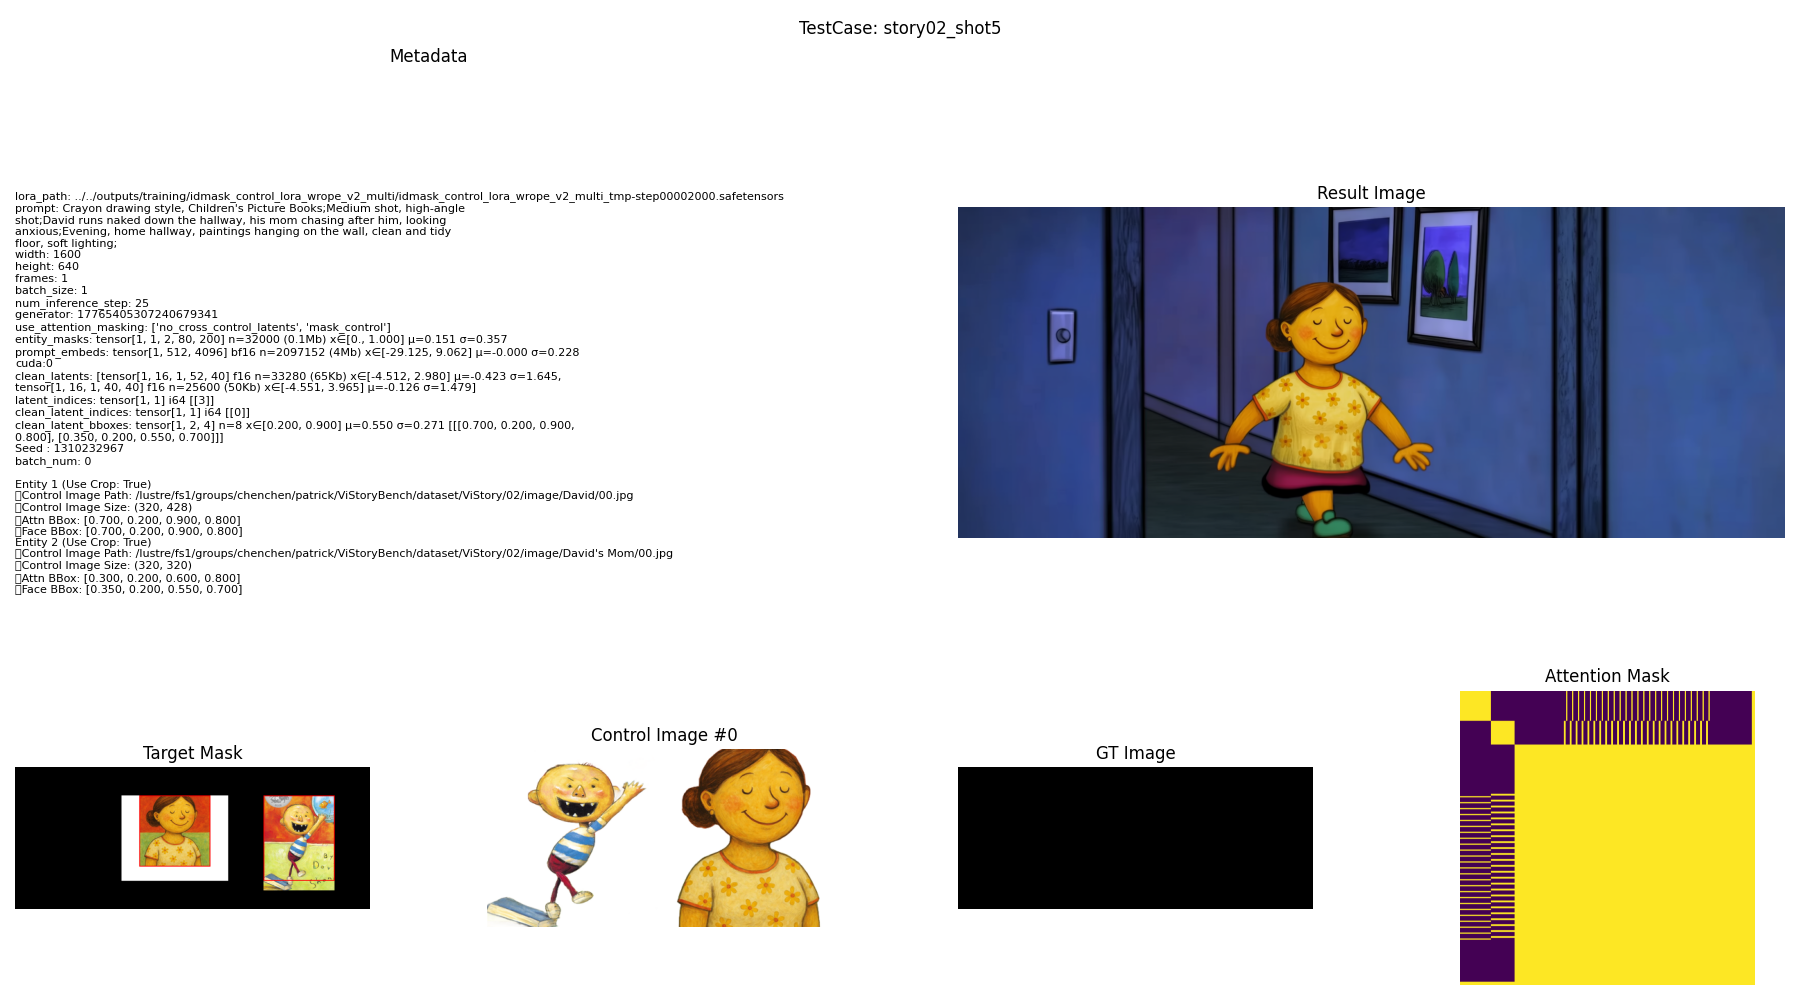

In [5]:
panel_id = '[PANEL-5]'
shot_num = min(start_shot_num + int(panel_id.replace('[PANEL-', '').replace(']', ''))-1, end_shot_num)

layout = joint_layout[panel_id].copy()
layout['body'] = [[700, 200, 900, 800], [300, 200, 600, 800]]
panel_layout, width, height = get_panel_layout(layout, page_w, page_h)

story_shot, characters_shot, prompt = get_info_from_vistorybench(vistory_dataset, story_num, shot_num)
# prompt = story_shot['type'] + ";" + prompt
prompt = (
    "Crayon drawing style, " + story_shot['type'] + ";"
    f"{story_shot['camera']};"
    f"{story_shot['script']};"
    f"{story_shot['scene']};"
)
# characters_shot = {'David' : {'images' : ['/lustre/fs1/groups/chenchen/patrick/ViStoryBench/dataset/ViStory/02/image/David/00.jpg']}}
print({k:v['images'] for k,v in characters_shot.items()})

# seed = np.random.randint(2**31)
seed = 1310232967
print(seed)
result_imgs, debug_imgs, debug_mask = framepack_model(
    prompt, panel_layout, characters_shot, width, height,
    c_width_given=320, seed=seed, use_rembg=True,
    debug_name=f"story{story_num}_shot{shot_num}"
)

results_dict[panel_id] = {
    'shot_num': shot_num, 'panel_layout': layout,
    'result_img': result_imgs[0], 'debug_img': debug_imgs[0],
    'debug_mask': debug_mask,
}
debug_imgs[0]

In [ ]:
panel_id = '[PANEL-4]'
layout = joint_layout[panel_id]
shot_num = min(start_shot_num + int(panel_id.replace('[PANEL-', '').replace(']', ''))-1, end_shot_num)
panel_layout, width, height = get_panel_layout(layout, page_w, page_h)

story_shot, characters_shot, prompt = get_info_from_vistorybench(vistory_dataset, story_num, shot_num)
prompt = story_shot['type'] + ";" + prompt
print({k:v['images'] for k,v in characters_shot.items()})

results_dict_temp = {}
for i in range(16):
    seed = np.random.randint(2**31)
    result_imgs, debug_imgs, debug_mask = framepack_model(
        prompt, panel_layout, characters_shot, width, height,
        c_width_given=320, seed=seed, 
        debug_name=f"story{story_num}_shot{shot_num}"
    )

    results_dict_temp[i] = {
        'seed' : seed,
        'shot_num': shot_num, 'panel_layout': layout,
        'result_img': result_imgs[0], 'debug_img': debug_imgs[0],
        'debug_mask': debug_mask,
    }

fig, ax = plt.subplots(4, 4, figsize=(12, 12))
for i, (key, value) in enumerate(results_dict_temp.items()):
    ax[i // 4, i % 4].imshow(value['result_img'])
    ax[i // 4, i % 4].set_title(f"Seed {value['seed']}")
    ax[i // 4, i % 4].axis('off')
plt.tight_layout()
plt.show()

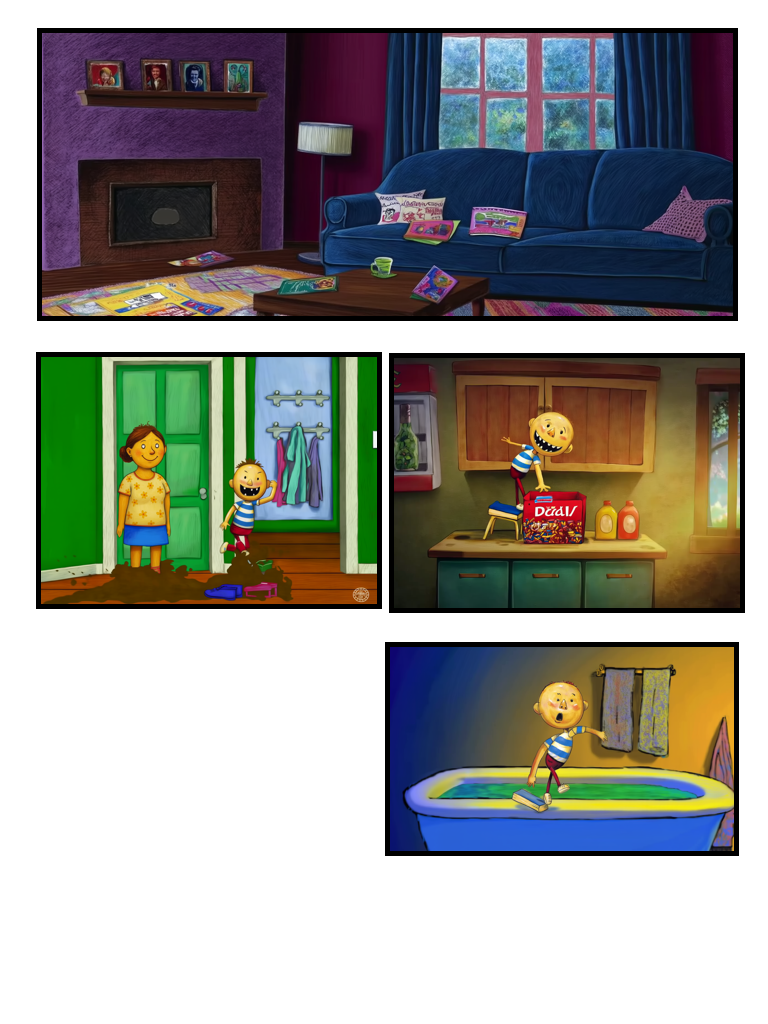

In [33]:
# results_dict['[PANEL-1]']['panel_layout'] = {'bbox': [10, 20, 990, 220],
#   'body': [[518, 69, 741, 894, 636, 228, 635, 347, 618, 206, 650, 201]]}
# results_dict['[PANEL-2]']['panel_layout'] = {'bbox': [10, 230, 990, 520],
#   'body': [[253, 227, 528, 968, 380, 314, 363, 393, 358, 297, 392, 297]]}
# results_dict['[PANEL-3]']['panel_layout'] = {'bbox': [10, 530, 990, 760],
#   'body': [[200, 100, 400, 900], [500, 300, 700, 900]]}
# results_dict['[PANEL-4]']['panel_layout'] = {'bbox': [10, 770, 990, 980],
#   'body': [[756, 140, 1000, 974, 818, 265, 856, 328, 806, 244, 830, 237],
#    [160, 37, 392, 962, 285, 142, 283, 238, 270, 121, 297, 119]]}


final_img = draw_final_img(results_dict, page_w, page_h, key='result_img', panel_width=5)
page_sub = convert_result_to_df_wpose({k: v['panel_layout'] for k,v in results_dict.items()}, page_w, page_h)
final_layout = annot_viz(Image.new("RGB", (page_w,page_h), (0,0,0)), page_sub, label_col='frame_id2')
final_img

In [40]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
out_dir = Path("../../outputs/figures") / f"{story_num}_{timestamp}"
out_dir.mkdir(parents=True, exist_ok=True)

final_img = draw_final_img(results_dict, page_w, page_h, key='result_img', panel_width=5)
final_mask = draw_final_img(results_dict, page_w, page_h, key='debug_mask', panel_width=0)
page_sub = convert_result_to_df_wpose(joint_layout, page_w, page_h)
final_layout = annot_viz(Image.new("RGB", (page_w,page_h), (0,0,0)), page_sub, label_col='frame_id2')

for panel_id, res in results_dict.items():
    shot_num = int(res['shot_num'])-1
    res['result_img'].save(out_dir / f"{story_num}_{shot_num}.png")
    res['debug_img'].save(out_dir / f"{story_num}_{shot_num}_debug.png")
final_img.save(out_dir / f"final.png")
final_mask.save(out_dir / f"final_mask.png")
final_layout.save(out_dir / f"final_layout.png")
(out_dir / "panel_layout.json").write_text(json.dumps({k: v['panel_layout'] for k,v in results_dict.items()}, indent=4))

1863